In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl
import duckdb
import time

## Step 1: The data ingestion and transformation steps.

### Loading Dataset

In [86]:
st = time.time()
df = pd.read_csv("/content/sensor_data.csv")
et = time.time()
print((et-st)*1000, "millisecond")

913.9964580535889 millisecond


In [87]:
df.shape

(1000000, 9)

## Creating new Column:

- A new column, combined_value, is derived by summing the two original columns.

In [88]:
df['combined_value'] = df['sensor_reading'] + df['control_value']

In [89]:
df.sample(2)

,sensor_id,sensor_reading,control_value,temperature,pressure,humidity,performance_metric,env_index,adjusted_sensor,combined_value
303431,444,91.53,53,34.14,1009.86,25.91,144.53,324.387,140.0409,144.53
461429,188,87.80,55,17.29,1009.03,21.32,142.80,316.021,136.0900,142.80


## Step 2: The analytical queries calculating the required statistics.

### Method 1: using pandas

In [18]:
import time

In [90]:
print("Dimensions of Dataset: ",df.shape)

st = time.time()
result = {
    'Mean': df[['sensor_reading','control_value','combined_value']].mean(),
    'Median': df[['sensor_reading','control_value','combined_value']].median(),
    'Mode': df[['sensor_reading','control_value','combined_value']].mode().iloc[0]  # Taking the first mode value in case of multiple modes
}
et = time.time()

print("Computation time: ", (et-st)*1000, "millisecond")
print("Computation time: ", (et-st), "second")

Dimensions of Dataset:  (1000000, 10)
Computation time:  114.53771591186523 millisecond
Computation time:  0.11453771591186523 second


In [ ]:
summary_df = pd.DataFrame(result)

In [14]:
temp = summary_df.iloc[[1,2,-1],:].T

In [15]:
temp

,sensor_reading,control_value,combined_value
Mean,100.000359,50.007403,150.007762
Median,100.010000,50.000000,149.960000
Mode,104.380000,50.000000,150.780000


### Method 2 : Using polar and duckdb

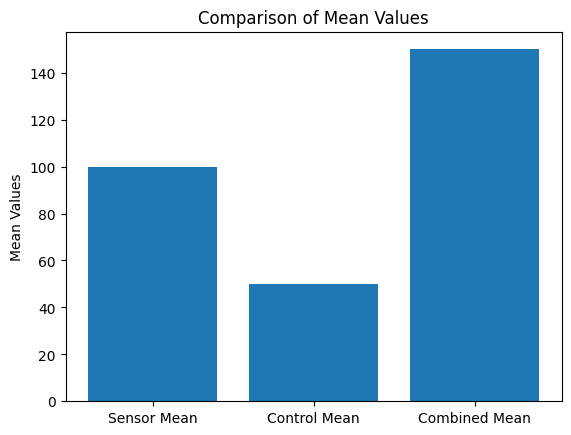

Time in milliseconds
Total Execution Time: 1586.53 ms
Data Ingestion Time: 0.41 ms
Data Processing Time: 156.74 ms
Statistical Computation Time: 406.66 ms
Visualization Time: 148.16 ms


Time in Seconds
Total Execution Time: 1.59s
Data Ingestion Time: 0.00s
Data Processing Time: 0.16s
Statistical Computation Time: 0.41s
Visualization Time: 0.15s


In [94]:
start_total = time.perf_counter()

df_lazy = pl.scan_csv("/content/sensor_data.csv")  # Keep it Lazy

df_lazy.sink_parquet("data.parquet")

start_ingest = time.time()
df_lazy = pl.scan_parquet("data.parquet")  # Load as LazyFrame
ingest_time = time.time() - start_ingest


start_processing = time.perf_counter()
df_lazy = df_lazy.with_columns(
    (pl.col("sensor_reading") + pl.col("control_value")).alias("combined_value")
)
df = df_lazy.collect()  # Convert to Eager DataFrame only here
end_processing = time.perf_counter()

start_stats = time.perf_counter()
query = """
    SELECT
        avg(sensor_reading) AS sensor_mean,
        median(sensor_reading) AS sensor_median,
        mode() WITHIN GROUP (ORDER BY sensor_reading) AS sensor_mode,
        avg(control_value) AS control_mean,
        median(control_value) AS control_median,
        mode() WITHIN GROUP (ORDER BY control_value) AS control_mode,
        avg(sensor_reading + control_value) AS combined_mean
    FROM df
"""
stats = duckdb.query(query).df()
end_stats = time.perf_counter()


start_viz = time.perf_counter()

stat_values = stats.iloc[0, [0, 3, 6]]  # Selecting required mean values


plt.bar(["Sensor Mean", "Control Mean", "Combined Mean"], stat_values)
plt.ylabel("Mean Values")
plt.title("Comparison of Mean Values")
plt.show()
end_viz = time.perf_counter()


end_total = time.perf_counter()

print("Time in milliseconds")
print(f"Total Execution Time: {(end_total - start_total) * 1000:.2f} ms")
print(f"Data Ingestion Time: {(ingest_time) * 1000:.2f} ms")
print(f"Data Processing Time: {(end_processing - start_processing) * 1000:.2f} ms")
print(f"Statistical Computation Time: {(end_stats - start_stats) * 1000:.2f} ms")
print(f"Visualization Time: {(end_viz - start_viz) * 1000:.2f} ms")

print('\n')

print("Time in Seconds")
print(f"Total Execution Time: {(end_total - start_total):.2f}s")
print(f"Data Ingestion Time: {(ingest_time):.2f}s")
print(f"Data Processing Time: {(end_processing - start_processing):.2f}s")
print(f"Statistical Computation Time: {(end_stats - start_stats):.2f}s")
print(f"Visualization Time: {(end_viz - start_viz):.2f}s")

In [16]:
cols = ['sensor_reading', 'control_value', 'combined_value']
c = ['r','g','b']

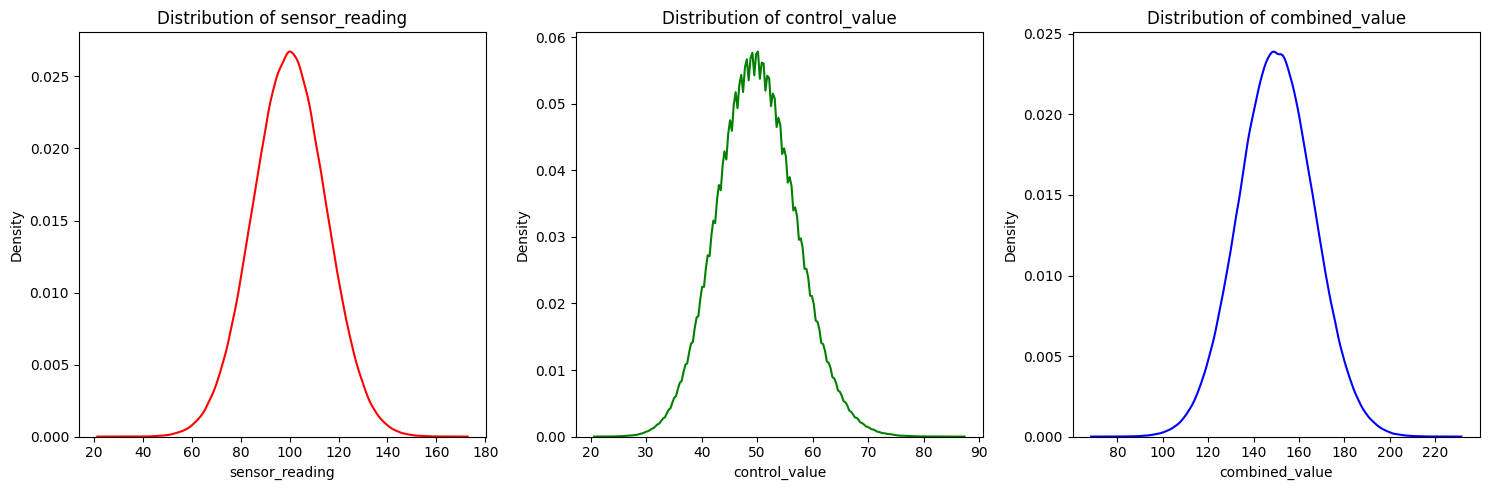

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i in cols:
  sns.kdeplot(data=df, x=i, ax=axes[cols.index(i)],color=c[cols.index(i)])
  axes[cols.index(i)].set_title(f'Distribution of {i}')

plt.tight_layout()
plt.show()

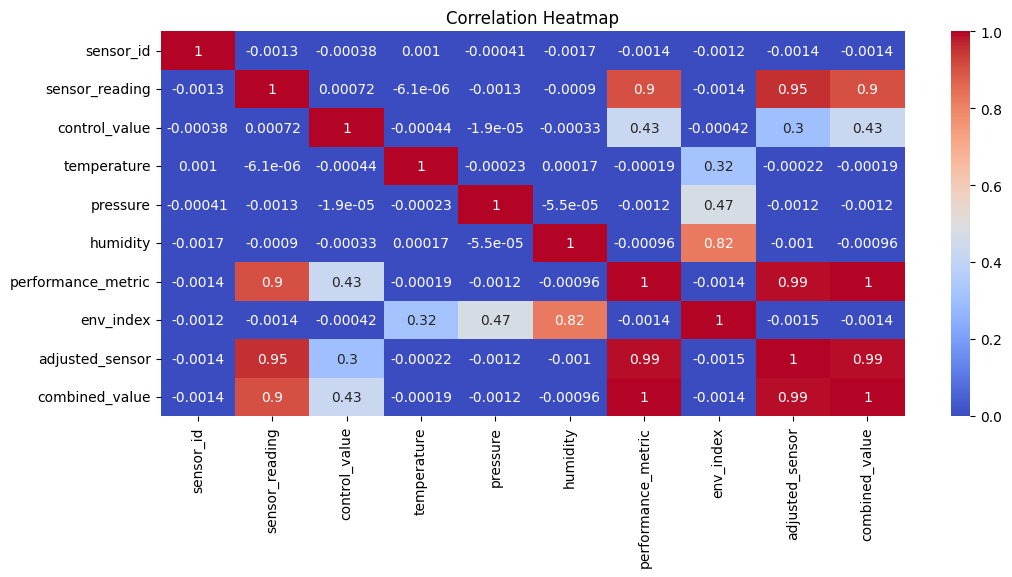

In [ ]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

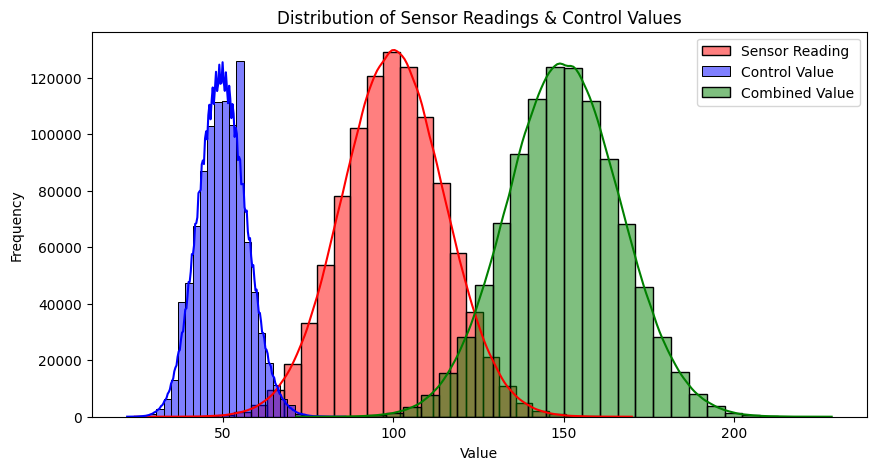

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df["sensor_reading"], bins=30, kde=True, color='red', label="Sensor Reading", alpha=0.5)
sns.histplot(df["control_value"], bins=30, kde=True, color='blue', label="Control Value", alpha=0.5)
sns.histplot(df["combined_value"], bins=30, kde=True, color='green', label="Combined Value", alpha=0.5)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Distribution of Sensor Readings & Control Values")
plt.legend()
plt.show()